# GlobeStay Marketing Response Models (by Country)

**Channels (performance):**
- Branded PPC (`cost_ppc_brand`)
- Non-Branded PPC (`cost_ppc_non_brand`)
- Metasearch (aggregated from Google Hotel Ads, Tripadvisor, Trivago, Other)
- Remarketing (`cost_remarketing`)
- Email (`cost_email`)

**Models:**
1. A **log–log** model (elasticities directly from coefficients)
2. An **ADBUDG** response model (nonlinear saturation: \(f(X)=a\,X^c/(X^c+d)\))

**Controls included:**
- Competition: `meta_comp_grp`, `ota_comp_grp` (log1p transformed)
- Seasonality: weekly Fourier terms (K=2)
- Trend: per-country time index
- Holidays: specified dummy columns (binary)

**Outputs:**
- Elasticities & marginal ROI (bookings per currency unit) for both models
- Diagnostic plots and response curves (matplotlib only, one chart per figure)
- Next-dollar **budget allocation recommendations** (raw & adjusted)

> **Note:** Financial ROI requires a contribution per booking. Here we report *bookings per currency*. Multiply by average contribution per booking to convert to financial ROI.

In [1]:
# Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from scipy.optimize import least_squares

pd.set_option('display.max_columns', 150)
plt.rcParams.update({'figure.dpi': 120})

# Parameters
DATA_PATH = '../data/cleaned_globestay.parquet'
OUTPUT_DIR = '../output/performance_channels/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
df = pd.read_parquet(DATA_PATH)
df.head()

,sales_interco,presidentsday_us_ca,sales_direct,cost_email,fb_cost,value_currency_rate,labourday_de_nw,cost_shop_other,sales_shop_other,boxingday,olv_net_spend_eur,cinema_net_spend_eur,sales_retargeting,olv_imps,brandtv_net_spend_eur,print_net_spend_eur,christmasday,newyearsday,cost_ppc_non_brand,sales_shop_trivago,sales_emk,cost_remarketing,clicks_email,drtv_grp,mayday_gb_en,ooh_net_spend_eur,fb_imps,germanunityday_de_nw,cost_shop_tripadvisor,display_net_spend_eur,display_imps,thanksgivingday_us_ca,clicks_shop_googleha,sales_shop_googleha,cost_ppc_brand,totbookings,bankholiday_gb_en,whitmonday_de_nw,clicks_ppc_non_brand,clicks_shop_trivago,cost_shop_googleha,yt_imps,radio_net_spend_eur,labourday_us_ca,ota_comp_grp,drtv_net_spend_eur,weekstart,sales_shop_tripadvisor,christsascensionday_de_nw,clicks_remarketing,cost_shop_trivago,sales_ppc_nonbrand,eastersunday,brandtv_grp,clicks_shop_tripadvisor,stvalentinesday,country,yt_cost,independenceday_us_ca,remembrance_memorialday_us_ca,martinl_kingsday_us_ca,clicks_ppc_brand,meta_comp_grp,eastermonday,sales_strat_part,sales_ppc_brand,clicks_shop_other,_source_sheet,country_std,week_start
0,867.0,0.0,183169.0,0.0,0.000000,1.0,0.0,103139.320644,4678.0,0.0,0.0,0.0,2040.0,0.0,0.0,0.0,0.0,0.0,2.196494e+06,18302.0,16703.0,58684.506092,474859.0,0.0,0.0,0.0,0.0,0.0,283108.460235,0.0,0.0,0.0,133462.122833,10423.0,68560.240287,398268.0,0.0,0.0,2.496438e+06,8.478270e+05,170087.676546,12.0,0.0,0.0,321.0,0.0,2016-01-04,9503.0,0.0,172069.878486,377911.565361,87808.0,0.0,0.0,367987.978037,0.0,de,0.000000,0.0,0.0,0.0,378640.216496,926.0,0.0,16547.0,48228.0,250527.000002,Sheet1,58684.506091931464,NaT
1,858.0,0.0,184480.0,0.0,89.386325,1.0,0.0,116137.878276,5019.0,0.0,0.0,0.0,2236.0,0.0,0.0,0.0,0.0,0.0,2.306422e+06,21148.0,16278.0,76380.207088,478024.0,0.0,0.0,0.0,57831.0,0.0,257639.565836,0.0,0.0,0.0,136016.480131,11107.0,70502.248076,404068.0,0.0,0.0,2.520208e+06,9.612325e+05,193176.386595,247.0,0.0,0.0,225.0,0.0,2016-01-11,9143.0,0.0,198123.396746,471254.197728,87383.0,0.0,0.0,353354.844840,0.0,de,0.000000,0.0,0.0,0.0,386722.377913,706.0,0.0,17340.0,49076.0,278878.649717,Sheet1,76380.20708756169,NaT
2,806.0,0.0,178895.0,0.0,231.027642,1.0,0.0,116345.872180,4963.0,0.0,0.0,0.0,2224.0,0.0,0.0,0.0,0.0,0.0,2.379034e+06,19715.0,15822.0,81636.483459,482391.0,0.0,0.0,0.0,104754.0,0.0,247711.892237,0.0,0.0,0.0,126167.255474,10048.0,61647.322276,388746.0,0.0,0.0,2.538803e+06,9.127736e+05,191568.477802,10249.0,0.0,0.0,231.0,0.0,2016-01-18,8568.0,0.0,186402.476444,439863.176592,85257.0,0.0,0.0,332119.415416,0.0,de,1.459669,0.0,0.0,1.0,372694.075197,813.0,0.0,16873.0,45575.0,288057.500725,Sheet1,81636.48345888322,NaT
3,770.0,0.0,178961.0,0.0,0.000000,1.0,0.0,117989.868406,5266.0,0.0,0.0,0.0,2498.0,0.0,0.0,0.0,0.0,0.0,2.342182e+06,22804.0,15441.0,97974.916607,477310.0,0.0,0.0,0.0,0.0,0.0,220940.048133,0.0,0.0,0.0,127212.718534,10234.0,58113.630201,391945.0,0.0,0.0,2.520338e+06,1.063155e+06,210296.033518,6144.0,0.0,0.0,224.0,0.0,2016-01-25,8065.0,0.0,203471.161091,499118.517506,84483.0,0.0,0.0,299462.651303,0.0,de,4.025302,0.0,0.0,0.0,367930.614827,1249.0,0.0,17386.0,46037.0,281681.767054,Sheet1,97974.91660718997,NaT
4,807.0,0.0,178238.0,0.0,476.436307,1.0,0.0,123253.978573,5186.0,0.0,0.0,0.0,2481.0,0.0,0.0,0.0,0.0,0.0,2.242276e+06,23259.0,15610.0,95282.006389,475233.0,0.0,0.0,0.0,248451.0,0.0,204314.700744,0.0,0.0,0.0,130732.603895,10490.0,56688.931152,389989.0,0.0,0.0,2.354455e+06,1.059135e+06,214412.055927,2.0,0.0,0.0,341.0,0.0,2016-02-01,7610.0,0.0,205548.009831,487391.446449,83448.0,0.0,0.0,281375.925071,0.0,de,0.009987,0.0,0.0,0.0,352899.330762,772.0,0.0,17840.0,45020.0,259377.433805,Sheet1,95282.00638886205,NaT


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   sales_interco                  576 non-null    float64       
 1   presidentsday_us_ca            576 non-null    float64       
 2   sales_direct                   576 non-null    float64       
 3   cost_email                     576 non-null    float64       
 4   fb_cost                        576 non-null    float64       
 5   value_currency_rate            576 non-null    float64       
 6   labourday_de_nw                576 non-null    float64       
 7   cost_shop_other                576 non-null    float64       
 8   sales_shop_other               576 non-null    float64       
 9   boxingday                      576 non-null    float64       
 10  olv_net_spend_eur              576 non-null    float64       
 11  cinema_net_spend_eu

In [3]:
# Select columns
SELECTED_COLS = [
    # Competition
    'meta_comp_grp','ota_comp_grp',
    # Controls
    'country','weekstart',
    # Holidays
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday',
    # Email
    'cost_email','clicks_email','sales_emk',
    # Non-brand PPC
    'cost_ppc_non_brand','sales_ppc_nonbrand','clicks_ppc_non_brand',
    # Brand PPC
    'sales_ppc_brand','clicks_ppc_brand','cost_ppc_brand',
    # Shopping site other
    'cost_shop_other','sales_shop_other','clicks_shop_other',
    # Trivago
    'sales_shop_trivago','clicks_shop_trivago','cost_shop_trivago',
    # Tripadvisor
    'clicks_shop_tripadvisor','sales_shop_tripadvisor','cost_shop_tripadvisor',
    # Google Hotel Ads
    'cost_shop_googleha','sales_shop_googleha','clicks_shop_googleha',
    # Remarketing
    'clicks_remarketing','cost_remarketing','sales_retargeting',
    # Dependent
    'totbookings','sales_interco','sales_direct','sales_strat_part',
    # Currency normalization
    'value_currency_rate',
]

In [4]:
# Load data (only selected columns)
df = pd.read_parquet(DATA_PATH)
df = df[[c for c in SELECTED_COLS if c in df.columns]].copy()
df['weekstart'] = pd.to_datetime(df['weekstart'])
countries = sorted(df['country'].dropna().unique().tolist())
display(df.head(3))
print('Rows:', len(df), '| Countries:', countries)

,meta_comp_grp,ota_comp_grp,country,weekstart,presidentsday_us_ca,labourday_de_nw,boxingday,eastermonday,martinl_kingsday_us_ca,remembrance_memorialday_us_ca,independenceday_us_ca,stvalentinesday,eastersunday,christsascensionday_de_nw,labourday_us_ca,whitmonday_de_nw,bankholiday_gb_en,thanksgivingday_us_ca,germanunityday_de_nw,mayday_gb_en,newyearsday,christmasday,cost_email,clicks_email,sales_emk,cost_ppc_non_brand,sales_ppc_nonbrand,clicks_ppc_non_brand,sales_ppc_brand,clicks_ppc_brand,cost_ppc_brand,cost_shop_other,sales_shop_other,clicks_shop_other,sales_shop_trivago,clicks_shop_trivago,cost_shop_trivago,clicks_shop_tripadvisor,sales_shop_tripadvisor,cost_shop_tripadvisor,cost_shop_googleha,sales_shop_googleha,clicks_shop_googleha,clicks_remarketing,cost_remarketing,sales_retargeting,totbookings,sales_interco,sales_direct,sales_strat_part,value_currency_rate
0,926.0,321.0,de,2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474859.0,16703.0,2.196494e+06,87808.0,2.496438e+06,48228.0,378640.216496,68560.240287,103139.320644,4678.0,250527.000002,18302.0,847827.012246,377911.565361,367987.978037,9503.0,283108.460235,170087.676546,10423.0,133462.122833,172069.878486,58684.506092,2040.0,398268.0,867.0,183169.0,16547.0,1.0
1,706.0,225.0,de,2016-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478024.0,16278.0,2.306422e+06,87383.0,2.520208e+06,49076.0,386722.377913,70502.248076,116137.878276,5019.0,278878.649717,21148.0,961232.479212,471254.197728,353354.844840,9143.0,257639.565836,193176.386595,11107.0,136016.480131,198123.396746,76380.207088,2236.0,404068.0,858.0,184480.0,17340.0,1.0
2,813.0,231.0,de,2016-01-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,482391.0,15822.0,2.379034e+06,85257.0,2.538803e+06,45575.0,372694.075197,61647.322276,116345.872180,4963.0,288057.500725,19715.0,912773.599042,439863.176592,332119.415416,8568.0,247711.892237,191568.477802,10048.0,126167.255474,186402.476444,81636.483459,2224.0,388746.0,806.0,178895.0,16873.0,1.0


Rows: 576 | Countries: ['de', 'gb', 'us']


In [5]:
# Feature engineering (metasearch aggregation, FX-normalized costs, seasonality)
df['cost_meta'] = df[['cost_shop_googleha','cost_shop_tripadvisor','cost_shop_trivago','cost_shop_other']].sum(axis=1)
df['sales_meta'] = df[['sales_shop_googleha','sales_shop_tripadvisor','sales_shop_trivago','sales_shop_other']].sum(axis=1)
df['clicks_meta'] = df[['clicks_shop_googleha','clicks_shop_tripadvisor','clicks_shop_trivago','clicks_shop_other']].sum(axis=1)

# FX-normalized costs
rate = df['value_currency_rate'].replace(0, np.nan).fillna(1.0)
for col in ['cost_email','cost_ppc_non_brand','cost_ppc_brand','cost_meta','cost_remarketing']:
    df[col+'_normalized'] = df[col] / rate

# Average booking value proxy
sales_cols = ['sales_emk','sales_ppc_nonbrand','sales_ppc_brand','sales_meta','sales_retargeting','sales_interco','sales_direct','sales_strat_part']
df['total_sales_perf'] = df[sales_cols].sum(axis=1)
df['avg_booking_value_proxy'] = np.where(df['totbookings']>0, df['total_sales_perf']/df['totbookings'], np.nan)

# Seasonality features
df = df.sort_values(['country','weekstart']).copy()
df['t'] = df.groupby('country').cumcount() + 1
df['woy'] = df['weekstart'].dt.isocalendar().week.astype(int)

# Add Fourier terms
def add_fourier_terms(df_sub, K=2):
    for k in range(1, K+1):
        df_sub[f'sin_{k}'] = np.sin(2*np.pi*k*df_sub['woy']/52.0)
        df_sub[f'cos_{k}'] = np.cos(2*np.pi*k*df_sub['woy']/52.0)
    return df_sub

df = pd.concat(
    [add_fourier_terms(g.copy(), K=2).assign(country=iname) for iname, g in df.groupby('country')],
    axis=0,
)

# Fill NA holiday dummies with 0
holiday_cols = [
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday'
]
df[holiday_cols] = df[holiday_cols].fillna(0)

## Log–log model by country
- Spec: `log(totbookings+1)` vs. `log(cost_*_normalized+1)` + competition + trend + Fourier seasonality + holiday dummies.
- HAC robust SE with `maxlags=4`.
- Elasticities = coefficients on log-costs.

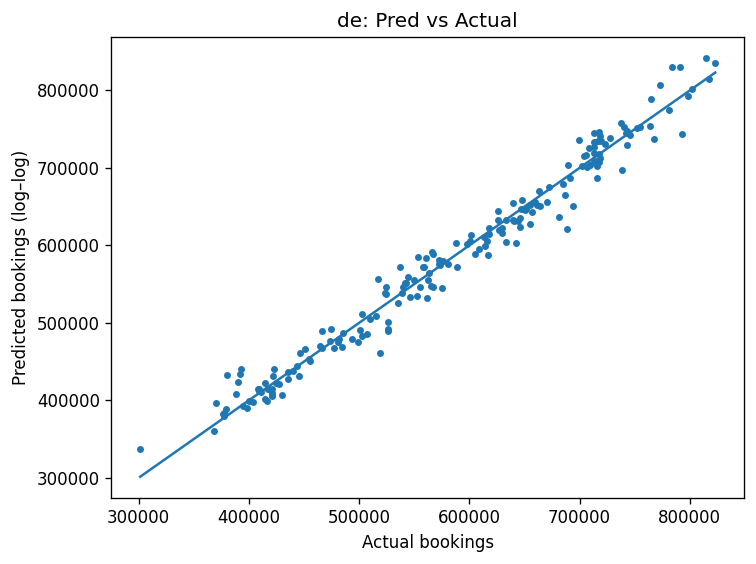

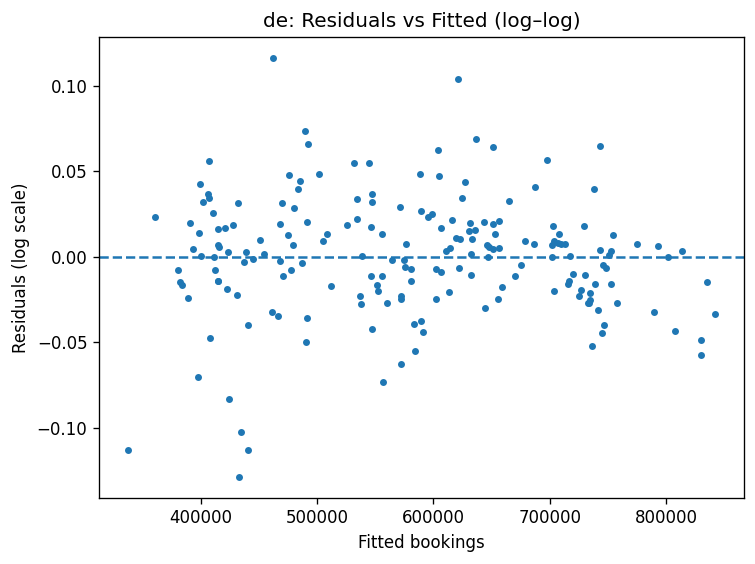

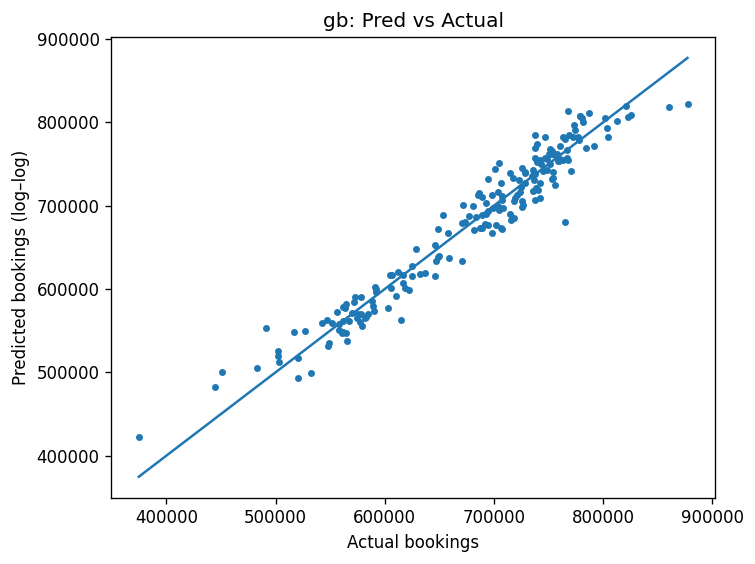

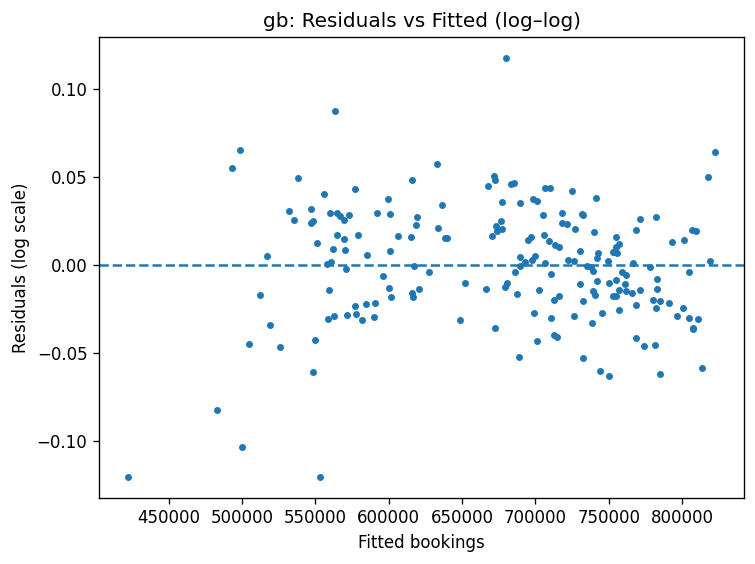

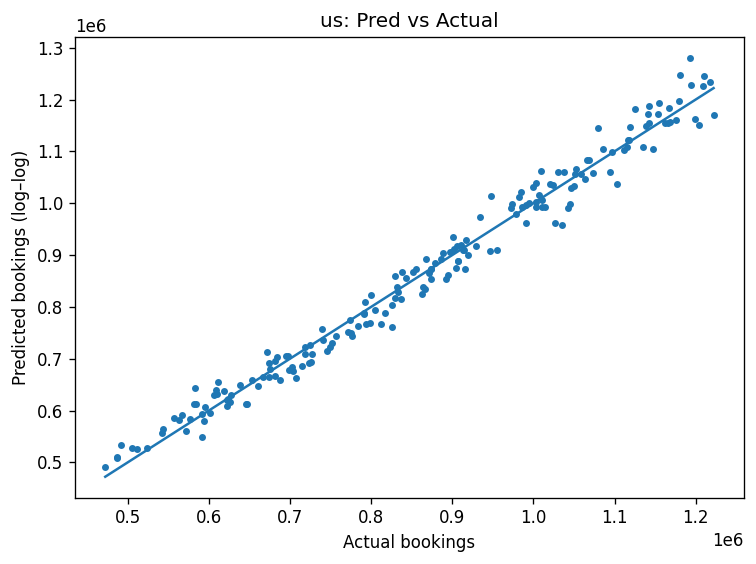

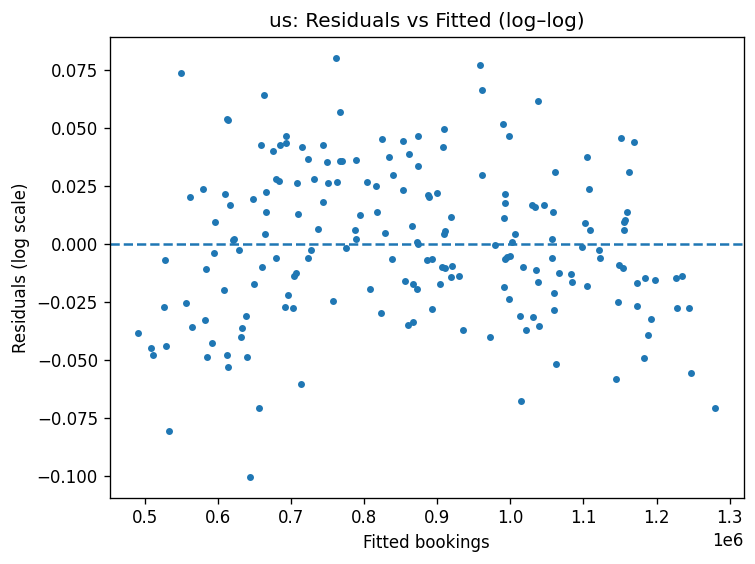

### Elasticities (Log-Log)

,country,channel,elasticity_loglog
0,de,Branded PPC,-4.427839e-03
1,de,Non-Branded PPC,1.313433e-01
2,de,Metasearch,1.700910e-01
3,de,Remarketing,9.913398e-02
4,de,Email,9.688742e-16
5,gb,Branded PPC,2.644500e-02
6,gb,Non-Branded PPC,2.464145e-01
7,gb,Metasearch,1.601741e-01
8,gb,Remarketing,4.033160e-02
9,gb,Email,-2.279776e-16


### Marginal ROI (Log-Log)

,country,channel,marginal_bookings_per_dollar_loglog,marginal_ROI_loglog_dollar_per_dollar
0,de,Branded PPC,-0.045287,-0.045287
1,de,Non-Branded PPC,0.028831,0.028831
2,de,Metasearch,0.082214,0.082214
3,de,Remarketing,0.576388,0.576388
4,de,Email,NaN,NaN
5,gb,Branded PPC,0.278320,0.278320
6,gb,Non-Branded PPC,0.056649,0.056649
7,gb,Metasearch,0.072730,0.072730
8,gb,Remarketing,0.349659,0.349659
9,gb,Email,NaN,NaN


In [6]:
# Log–log model by country
def fit_loglog_country(dfc):
    y = np.log1p(dfc['totbookings'])
    X = pd.DataFrame({
        'ln_cost_brand'     : np.log1p(dfc['cost_ppc_brand_normalized']),
        'ln_cost_nonbrand'  : np.log1p(dfc['cost_ppc_non_brand_normalized']),
        'ln_cost_meta'      : np.log1p(dfc['cost_meta_normalized']),
        'ln_cost_remarketing': np.log1p(dfc['cost_remarketing_normalized']),
        'ln_cost_email'     : np.log1p(dfc['cost_email_normalized']),
        'meta_comp_grp'     : dfc['meta_comp_grp'],
        'ota_comp_grp'      : dfc['ota_comp_grp'],
        't'                 : dfc['t'],
        'sin_1'             : dfc['sin_1'],'cos_1': dfc['cos_1'],
        'sin_2'             : dfc['sin_2'],'cos_2': dfc['cos_2'],
    })
    X[holiday_cols] = dfc[holiday_cols]
    X = add_constant(X, has_constant='add')
    model = OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':4})
    return model, X, y

loglog_results = {}
elasticity_rows, roi_rows = [], []

# Fit models and compute diagnostics
for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    if dsub['totbookings'].notna().sum() < 30:
        display(Markdown(f"**Skipping {ctry}**: not enough data"))
        continue
    mdl, X, y = fit_loglog_country(dsub)
    loglog_results[ctry] = mdl
    yhat = mdl.predict(X)
    
    # Diagnostics: predicted vs actual (levels)
    plt.figure()
    plt.scatter(np.expm1(y), np.expm1(yhat), s=10)
    lo, hi = float(np.expm1(y).min()), float(np.expm1(y).max())
    plt.plot([lo,hi],[lo,hi])
    plt.xlabel('Actual bookings'); plt.ylabel('Predicted bookings (log–log)'); plt.title(f'{ctry}: Pred vs Actual')
    plt.tight_layout(); plt.show(); plt.close()
    
    # Residuals vs fitted
    resid = y - yhat
    plt.figure()
    plt.scatter(np.expm1(yhat), resid, s=10)
    plt.axhline(0, linestyle='--')
    plt.xlabel('Fitted bookings'); plt.ylabel('Residuals (log scale)'); plt.title(f'{ctry}: Residuals vs Fitted (log–log)')
    plt.tight_layout(); plt.show(); plt.close()
    
    # Elasticities and marginal ROI
    elasticities = {
        'Branded PPC'      : mdl.params.get('ln_cost_brand', np.nan),
        'Non-Branded PPC'  : mdl.params.get('ln_cost_nonbrand', np.nan),
        'Metasearch'       : mdl.params.get('ln_cost_meta', np.nan),
        'Remarketing'      : mdl.params.get('ln_cost_remarketing', np.nan),
        'Email'            : mdl.params.get('ln_cost_email', np.nan)
    }
    mean_Y = dsub['totbookings'].mean()
    mean_costs = {
        'Branded PPC'      : dsub['cost_ppc_brand_normalized'].replace(0,np.nan).mean(),
        'Non-Branded PPC'  : dsub['cost_ppc_non_brand_normalized'].replace(0,np.nan).mean(),
        'Metasearch'       : dsub['cost_meta_normalized'].replace(0,np.nan).mean(),
        'Remarketing'      : dsub['cost_remarketing_normalized'].replace(0,np.nan).mean(),
        'Email'            : dsub['cost_email_normalized'].replace(0,np.nan).mean()
    }
    avg_value = dsub['avg_booking_value_proxy'].replace([np.inf,-np.inf],np.nan).median()
    
    # Compute and store elasticity and marginal ROI
    for ch, beta in elasticities.items():
        Xbar = mean_costs.get(ch, np.nan)
        if np.isnan(beta) or not np.isfinite(beta) or Xbar is None or Xbar<=0 or pd.isna(avg_value) or avg_value<=0:
            m_roi = np.nan; m_bpd = np.nan
        else:
            m_bpd = beta * (mean_Y / Xbar)
            m_roi = m_bpd * avg_value
        elasticity_rows.append({'country': ctry, 'channel': ch, 'elasticity_loglog': beta})
        roi_rows.append({'country': ctry, 'channel': ch,
                         'marginal_bookings_per_dollar_loglog': m_bpd,
                         'marginal_ROI_loglog_dollar_per_dollar': m_roi})

elasticity_df = pd.DataFrame(elasticity_rows)
roi_df = pd.DataFrame(roi_rows)
display(Markdown('### Elasticities (Log-Log)'))
display(elasticity_df)
display(Markdown('### Marginal ROI (Log-Log)'))
display(roi_df)

## ADBUDG model (nonlinear saturation) by country
Controls-only baseline → incremental bookings → ADBUDG curves per channel combined.

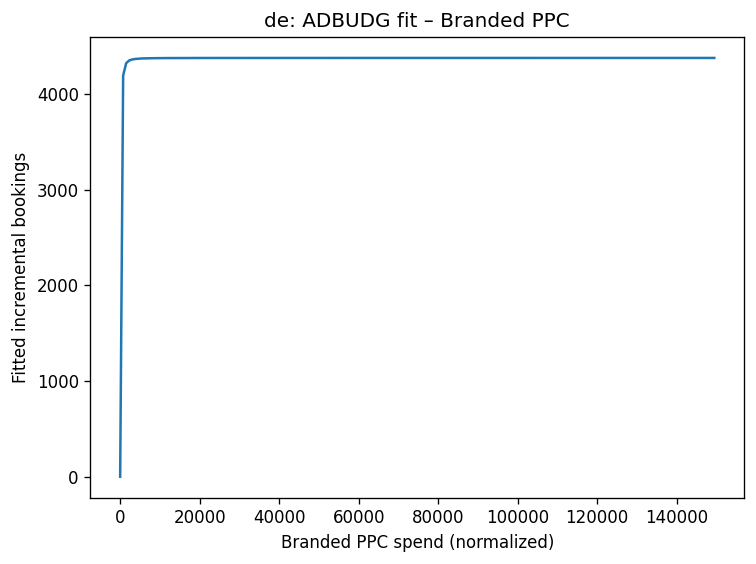

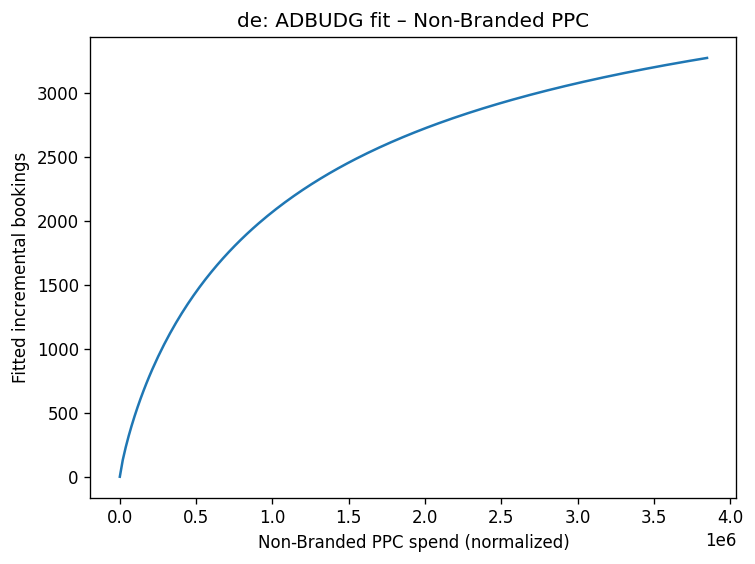

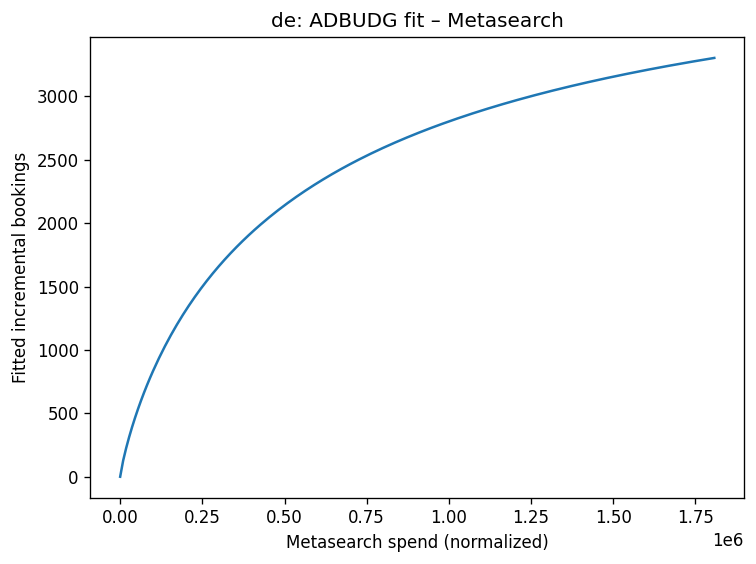

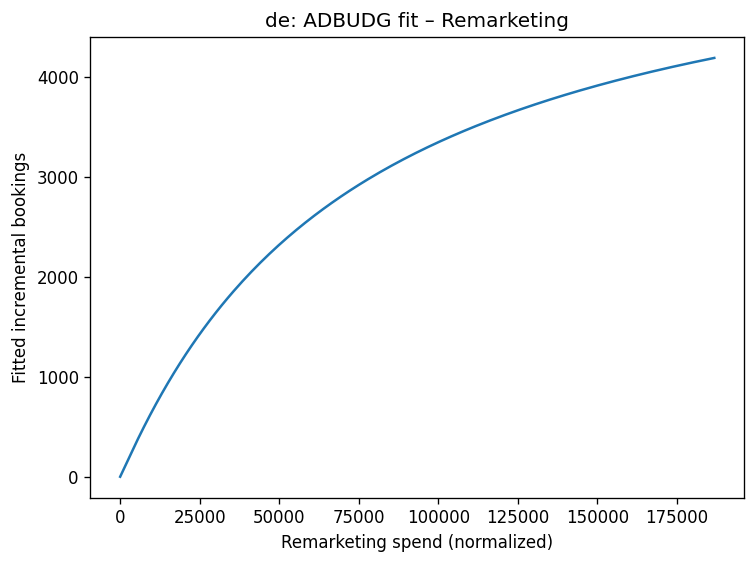

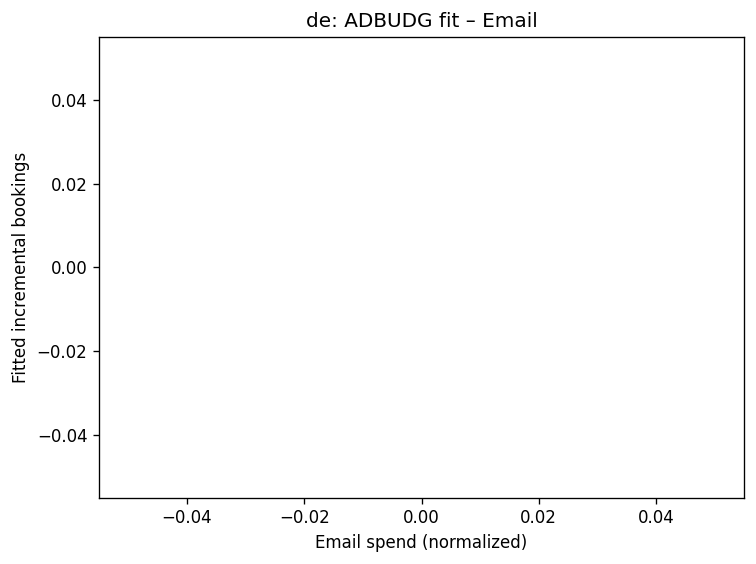

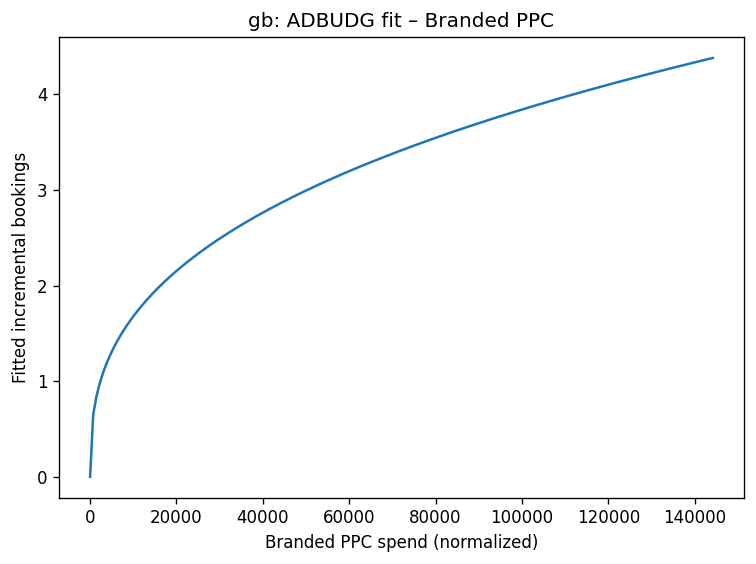

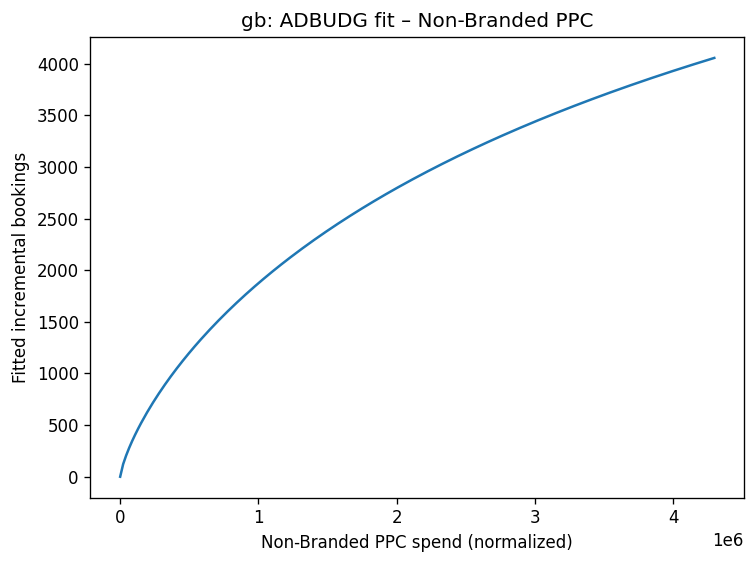

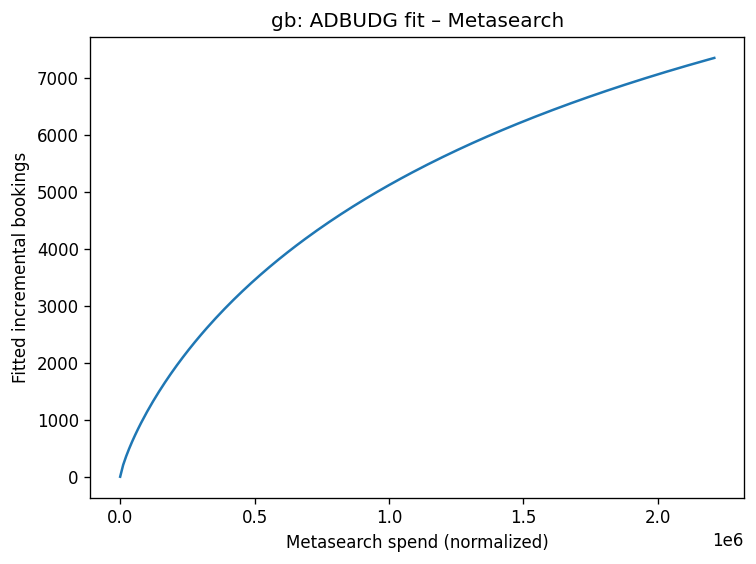

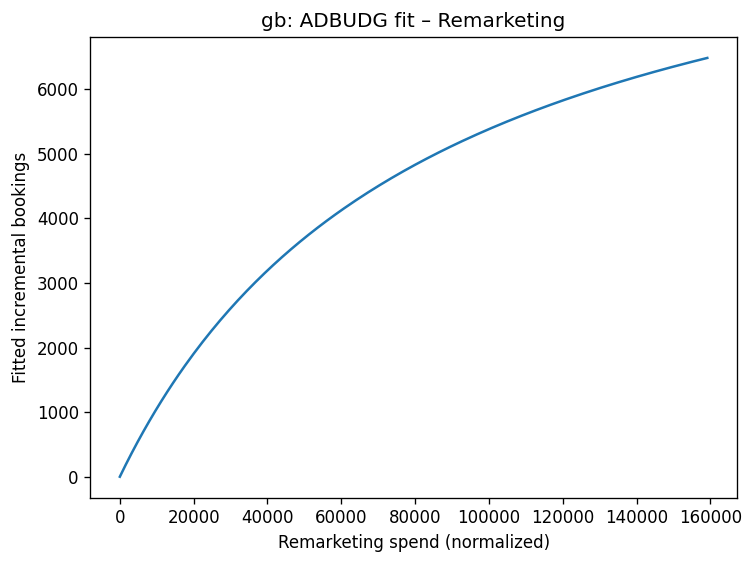

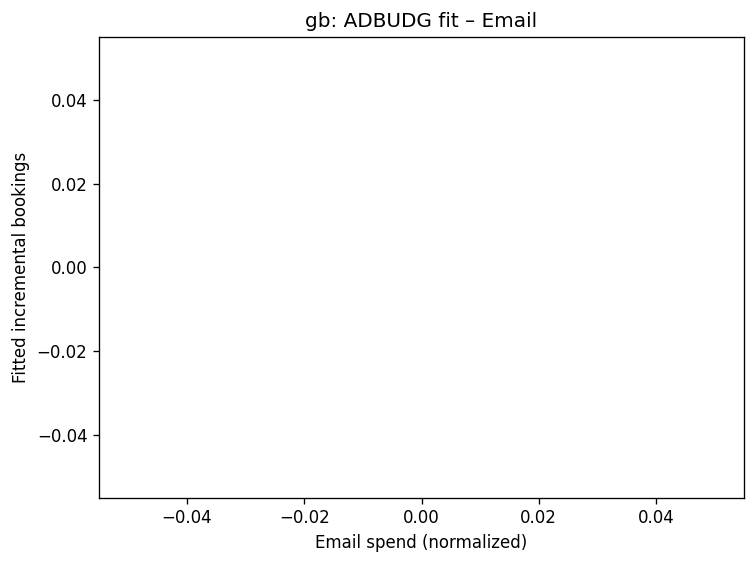

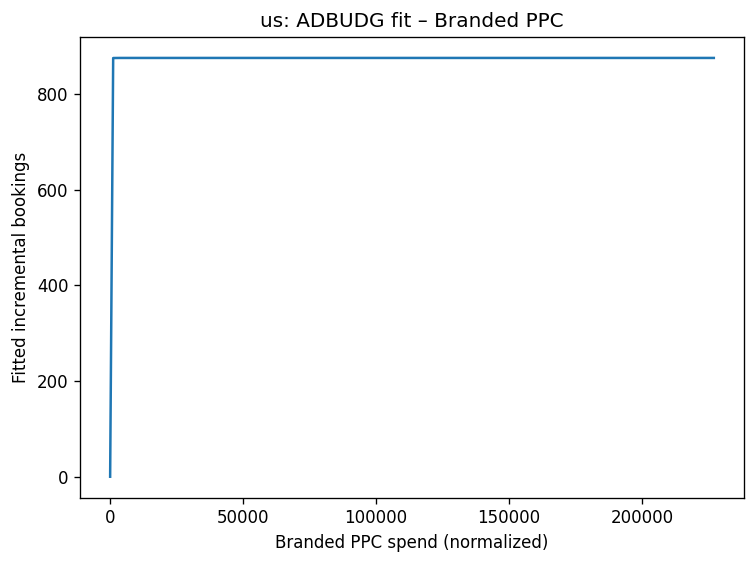

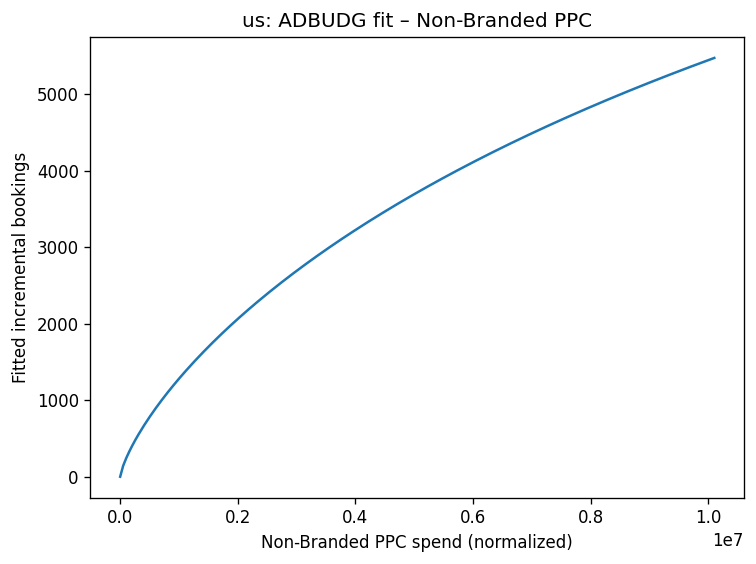

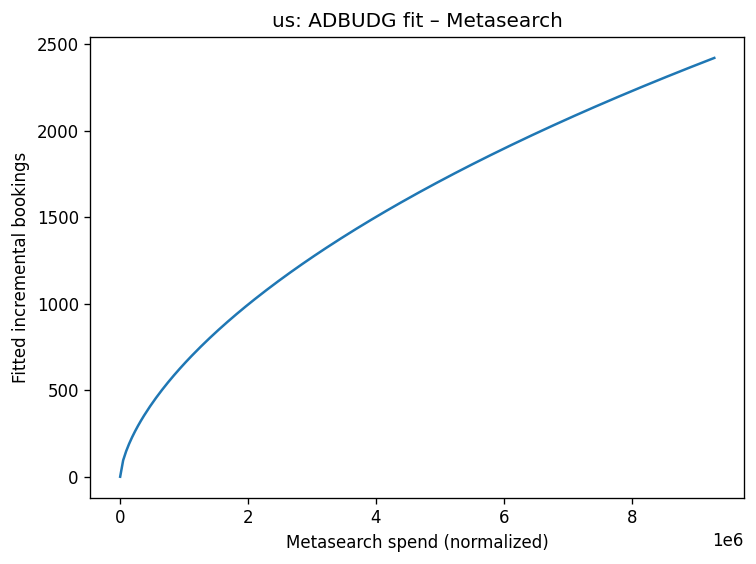

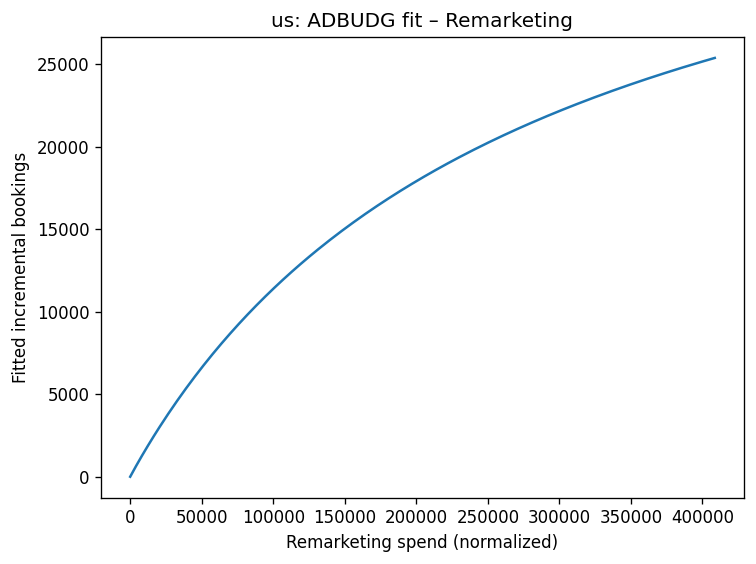

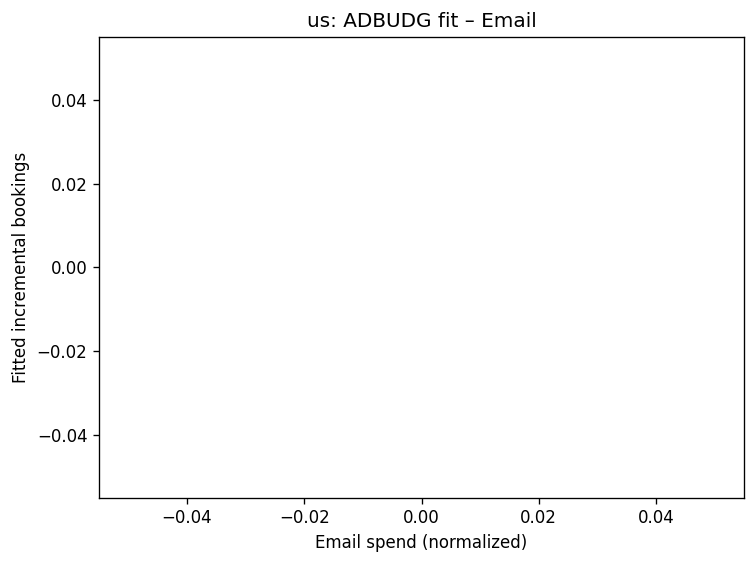

### ADBUDG Parameters (a, c, d)

,country,channel,a,c,d
0,de,Branded PPC,4377.040689,1.782954,5887.405714
1,de,Non-Branded PPC,4501.429087,0.848174,144015.497157
2,de,Metasearch,4528.678447,0.856711,85111.381008
3,de,Remarketing,5804.407903,1.030380,104428.963400
4,de,Email,2733.969670,0.800000,1.000000
5,gb,Branded PPC,844.053006,0.361000,13961.121241
6,gb,Non-Branded PPC,9305.994313,0.767883,160597.648557
7,gb,Metasearch,14279.811787,0.809111,127949.526531
8,gb,Remarketing,9931.192308,0.998105,82689.482805
9,gb,Email,2765.075636,0.800000,1.000000


### Elasticities (ADBUDG)

,country,channel,elasticity_ADBUDG_total,elasticity_ADBUDG_component
0,de,Branded PPC,2.622999e-07,3.488684e-05
1,de,Non-Branded PPC,1.469707e-03,2.875715e-01
2,de,Metasearch,1.504887e-03,2.950965e-01
3,de,Remarketing,2.508529e-03,4.365429e-01
4,de,Email,NaN,NaN
5,gb,Branded PPC,1.740223e-06,3.595978e-01
6,gb,Non-Branded PPC,2.448335e-03,4.865904e-01
7,gb,Metasearch,4.193567e-03,4.563183e-01
8,gb,Remarketing,3.652089e-03,5.184652e-01
9,gb,Email,NaN,NaN


### Marginal ROI (ADBUDG)

,country,channel,marginal_bookings_per_dollar_ADBUDG,marginal_ROI_ADBUDG_dollar_per_dollar
0,de,Branded PPC,2.682771e-06,2.682771e-06
1,de,Non-Branded PPC,3.226135e-04,3.226135e-04
2,de,Metasearch,7.273915e-04,7.273915e-04
3,de,Remarketing,1.458516e-02,1.458516e-02
4,de,Email,NaN,NaN
5,gb,Branded PPC,1.831498e-05,1.831498e-05
6,gb,Non-Branded PPC,5.628573e-04,5.628573e-04
7,gb,Metasearch,1.904158e-03,1.904158e-03
8,gb,Remarketing,3.166217e-02,3.166217e-02
9,gb,Email,NaN,NaN


In [7]:
# ADBUDG model
def controls_only_base(dfc):
    y = np.log1p(dfc['totbookings'])
    Xc = pd.DataFrame({
        'meta_comp_grp': dfc['meta_comp_grp'],
        'ota_comp_grp' : dfc['ota_comp_grp'],
        't'            : dfc['t'],
        'sin_1'        : dfc['sin_1'], 'cos_1': dfc['cos_1'],
        'sin_2'        : dfc['sin_2'], 'cos_2': dfc['cos_2'],
    })
    Xc[holiday_cols] = dfc[holiday_cols]
    Xc = add_constant(Xc, has_constant='add')
    mdl = OLS(y, Xc, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':4})
    base_level = np.expm1(mdl.predict(Xc))
    return mdl, base_level

# Define channels and ADBUDG functions
channels = [
    ('Branded PPC', 'cost_ppc_brand_normalized'),
    ('Non-Branded PPC', 'cost_ppc_non_brand_normalized'),
    ('Metasearch', 'cost_meta_normalized'),
    ('Remarketing', 'cost_remarketing_normalized'),
    ('Email', 'cost_email_normalized')
]

# ADBUDG functions
def adbudg_sum(params, Xmat):
    n = Xmat.shape[0]; k = Xmat.shape[1]
    yhat = np.zeros(n)
    for j in range(k):
        a = params[3*j+0]; c = params[3*j+1]; d = params[3*j+2]
        X = np.maximum(Xmat[:,j], 0.0)
        num = np.power(X, c)
        yhat += a * (num / (num + d + 1e-9))
    return yhat

# Residuals function for least squares
def residuals_adbudg(params, Xmat, y_inc):
    return adbudg_sum(params, Xmat) - y_inc

adb_params_rows, adb_elasticity_rows, adb_roi_rows = [], [], []

# Fit ADBUDG models by country
for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    if dsub['totbookings'].notna().sum() < 30:
        continue
    base_mdl, base_lvl = controls_only_base(dsub)
    y_inc = (dsub['totbookings'] - base_lvl).clip(lower=0)
    Xmat = dsub[[col for _, col in channels]].fillna(0.0).values.astype(float)
    y_scale = max(y_inc.mean(), 1.0)
    a0 = [y_scale/len(channels)] * len(channels)
    c0 = [0.8] * len(channels)
    d0 = []
    
    # Initial d parameters based on median spend
    for _, col in channels:
        medx = np.nanmedian(dsub[col].values)
        medx = medx if np.isfinite(medx) and medx>0 else 1.0
        d0.append(np.power(medx, 0.8))
    p0 = []
    
    # Initial parameter vector
    for i in range(len(channels)):
        p0 += [a0[i], c0[i], d0[i]]
    p0 = np.array(p0, dtype=float)
    lower, upper = [], []

    # Set bounds for optimization
    for i in range(len(channels)):
        lower += [0.0, 0.1, 1e-6]
        upper += [10.0*y_scale, 3.0, 1e9]
    lower = np.array(lower); upper = np.array(upper)
    res = least_squares(residuals_adbudg, p0, bounds=(lower, upper), args=(Xmat, y_inc))
    params = res.x
    
    # Show fitted curves inline
    for j,(ch,col) in enumerate(channels):
        a = params[3*j+0]; cpar = params[3*j+1]; dpar = params[3*j+2]
        xs = np.linspace(0, np.nanpercentile(dsub[col].values, 99), 200)
        num = np.power(xs, cpar)
        ys = a * (num / (num + dpar + 1e-9))
        plt.figure()
        plt.plot(xs, ys)
        plt.xlabel(f"{ch} spend (normalized)"); plt.ylabel("Fitted incremental bookings")
        plt.title(f"{ctry}: ADBUDG fit – {ch}")
        plt.tight_layout(); plt.show(); plt.close()
    
    # Store params and compute elasticities/ROI at mean spend
    for j,(ch,col) in enumerate(channels):
        a = params[3*j+0]; cpar = params[3*j+1]; dpar = params[3*j+2]
        adb_params_rows.append({'country': ctry, 'channel': ch, 'a': a, 'c': cpar, 'd': dpar})
        Xbar = np.nanmean(dsub[col].values)

        # Compute elasticities and marginal ROI
        if Xbar is None or not np.isfinite(Xbar) or Xbar<=0:
            e_component = np.nan; e_total = np.nan; m_bpd = np.nan; m_roi = np.nan
        else:
            num = Xbar**cpar
            e_component = cpar * dpar / (num + dpar)
            dfdX = a * cpar * dpar * (Xbar**(cpar-1)) / ((Xbar**cpar + dpar)**2)
            Ybar = dsub['totbookings'].mean()
            e_total = dfdX * Xbar / Ybar if (Ybar and Ybar>0) else np.nan
            m_bpd = dfdX
            avg_value = dsub['avg_booking_value_proxy'].replace([np.inf,-np.inf],np.nan).median()
            m_roi = m_bpd * avg_value if (avg_value and avg_value>0) else np.nan
        adb_elasticity_rows.append({'country': ctry, 'channel': ch,
                                    'elasticity_ADBUDG_total': e_total,
                                    'elasticity_ADBUDG_component': e_component})
        adb_roi_rows.append({'country': ctry, 'channel': ch,
                             'marginal_bookings_per_dollar_ADBUDG': m_bpd,
                             'marginal_ROI_ADBUDG_dollar_per_dollar': m_roi})

adb_params_df = pd.DataFrame(adb_params_rows)
adb_elasticity_df = pd.DataFrame(adb_elasticity_rows)
adb_roi_df = pd.DataFrame(adb_roi_rows)
display(Markdown('### ADBUDG Parameters (a, c, d)'))
display(adb_params_df)
display(Markdown('### Elasticities (ADBUDG)'))
display(adb_elasticity_df)
display(Markdown('### Marginal ROI (ADBUDG)'))
display(adb_roi_df)

## Model comparison

In [8]:
# Model comparison per country/channel
comparison_rows = []
for ctry in countries:
    for ch, _ in channels:
        loglog_elast = elasticity_df[(elasticity_df['country']==ctry) & (elasticity_df['channel']==ch)]['elasticity_loglog'].values
        adb_elast = adb_elasticity_df[(adb_elasticity_df['country']==ctry) & (adb_elasticity_df['channel']==ch)]['elasticity_ADBUDG_total'].values
        if len(loglog_elast)==0 or len(adb_elast)==0:
            continue
        loglog_elast = loglog_elast[0]
        adb_elast = adb_elast[0]
        # Choose model with higher absolute elasticity
        if abs(loglog_elast) >= abs(adb_elast):
            best_model = 'Log-Log'
            best_elast = loglog_elast
        else:
            best_model = 'ADBUDG'
            best_elast = adb_elast
        comparison_rows.append({'country': ctry, 'channel': ch,
                                'best_model': best_model,
                                'best_elasticity': best_elast})
comparison_df = pd.DataFrame(comparison_rows)
display(Markdown('### Model Comparison and Best Model Selection'))
display(comparison_df)

### Model Comparison and Best Model Selection

,country,channel,best_model,best_elasticity
0,de,Branded PPC,Log-Log,-0.004428
1,de,Non-Branded PPC,Log-Log,0.131343
2,de,Metasearch,Log-Log,0.170091
3,de,Remarketing,Log-Log,0.099134
4,de,Email,ADBUDG,NaN
5,gb,Branded PPC,Log-Log,0.026445
6,gb,Non-Branded PPC,Log-Log,0.246415
7,gb,Metasearch,Log-Log,0.160174
8,gb,Remarketing,Log-Log,0.040332
9,gb,Email,ADBUDG,NaN


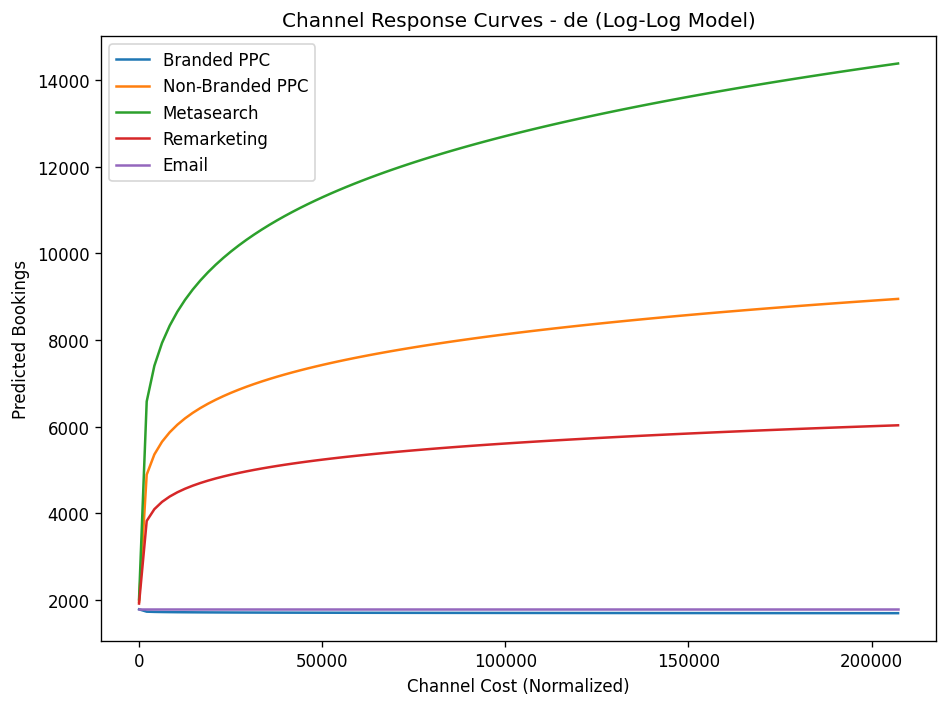

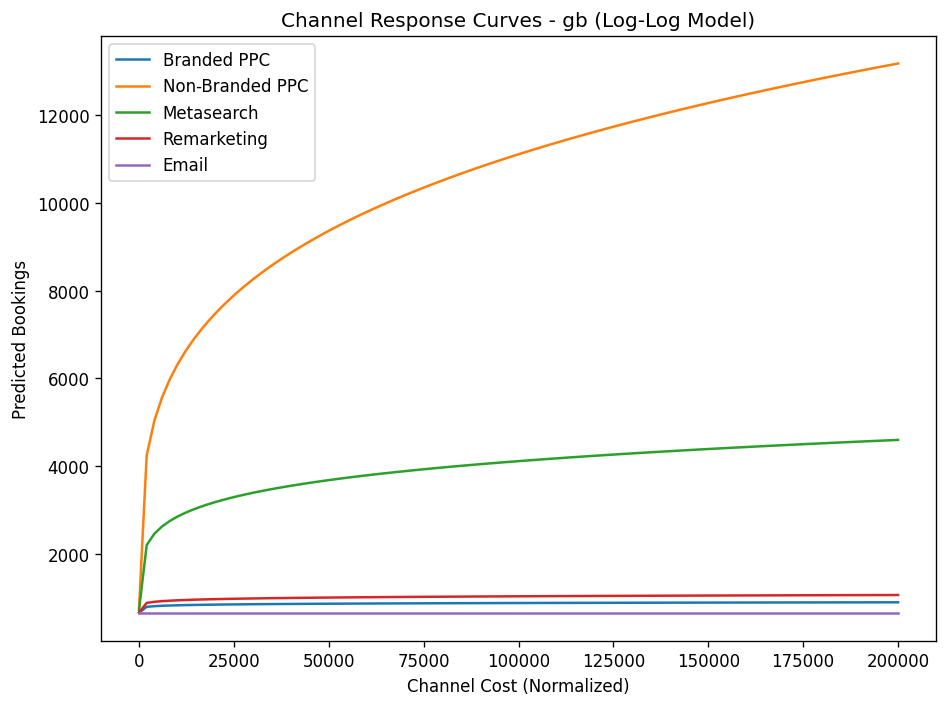

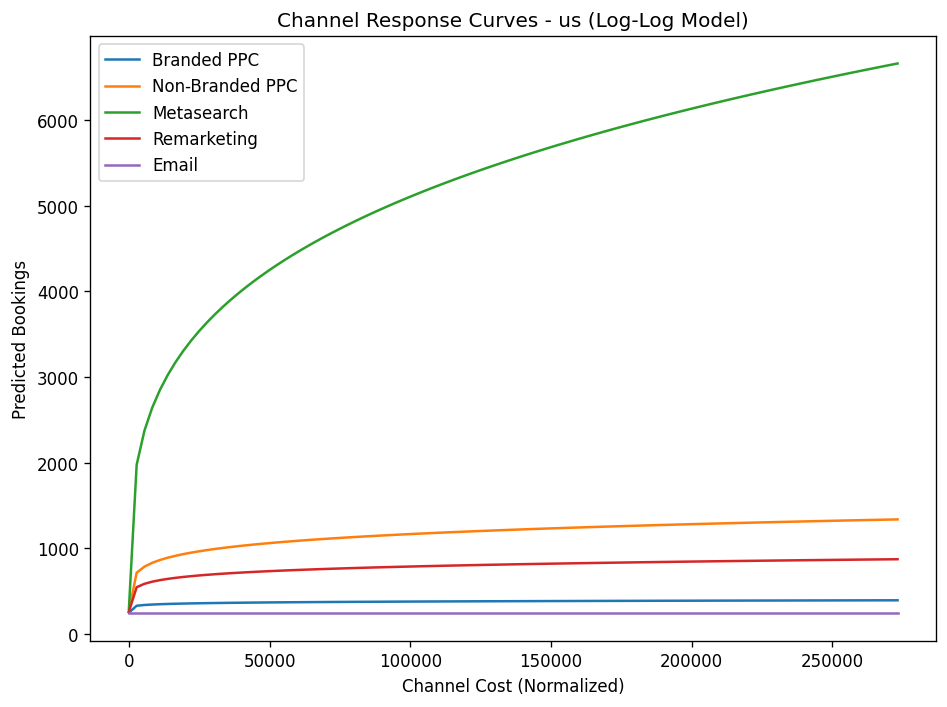

In [9]:
# Channel Response Curves (Log-Log)
channels = ['Branded PPC', 'Non-Branded PPC', 'Metasearch', 'Remarketing', 'Email']
cost_cols = {
    'Branded PPC': 'cost_ppc_brand_normalized',
    'Non-Branded PPC': 'cost_ppc_non_brand_normalized',
    'Metasearch': 'cost_meta_normalized',
    'Remarketing': 'cost_remarketing_normalized',
    'Email': 'cost_email_normalized'
}
for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    if dsub['totbookings'].notna().sum() < 30:
        continue
    mdl = loglog_results[ctry]
    
    plt.figure(figsize=(8,6))
    cost_range = np.linspace(1, dsub[cost_cols[channels[0]]].max()*1.2, 100)
    for ch in channels:
        beta = mdl.params.get(f'ln_cost_{"brand" if ch=="Branded PPC" else "nonbrand" if ch=="Non-Branded PPC" else "meta" if ch=="Metasearch" else "remarketing" if ch=="Remarketing" else "email"}', np.nan)
        if np.isnan(beta) or not np.isfinite(beta):
            continue
        # Predicted bookings change with cost
        pred_bookings = np.expm1(mdl.params['const'] + beta * np.log1p(cost_range))
        plt.plot(cost_range, pred_bookings, label=ch)
    
    plt.xlabel('Channel Cost (Normalized)')
    plt.ylabel('Predicted Bookings')
    plt.title(f'Channel Response Curves - {ctry} (Log-Log Model)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

## Budget reallocation via elasticity ratios
Recommended shares ∝ elasticities (prefer log–log total; fallback to ADBUDG).

In [10]:
# Budget reallocation recommendations
realloc_rows = []
for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    spend_cols = { 'Branded PPC':'cost_ppc_brand_normalized','Non-Branded PPC':'cost_ppc_non_brand_normalized',
                   'Metasearch':'cost_meta_normalized','Remarketing':'cost_remarketing_normalized','Email':'cost_email_normalized' }
    mean_spend = {ch: dsub[col].replace(0,np.nan).mean() for ch,col in spend_cols.items()}
    total_spend = np.nansum(list(mean_spend.values()))
    if total_spend<=0 or np.isnan(total_spend):
        continue
    curr_share = {ch: (val/total_spend if val>0 else 0.0) for ch,val in mean_spend.items()}
    e_adb = adb_elasticity_df[adb_elasticity_df['country']==ctry].set_index('channel')['elasticity_ADBUDG_total'].to_dict()
    e_ll = elasticity_df[elasticity_df['country']==ctry].set_index('channel')['elasticity_loglog'].to_dict()
    e_use = {}
    
    # Determine spend allocation based on elasticities
    for ch in spend_cols.keys():
        val = e_ll.get(ch, np.nan)
        if not np.isfinite(val) or pd.isna(val) or val<=0:
            val = e_adb.get(ch, np.nan)
        e_use[ch] = val if np.isfinite(val) and val>0 else 0.0
    sume = sum(e_use.values())
    if sume <= 0:
        continue
    rec_share = {ch: e_use[ch]/sume for ch in spend_cols.keys()}
    for ch in spend_cols.keys():
        realloc_rows.append({'country': ctry, 'channel': ch,
                             'current_share': curr_share.get(ch, np.nan),
                             'recommended_share': rec_share.get(ch, np.nan),
                             'shift_pp': 100*(rec_share.get(ch,0)-curr_share.get(ch,0))})

realloc_df = pd.DataFrame(realloc_rows)
display(Markdown('### Budget Reallocation Recommendations (percentage point shifts)'))
display(realloc_df)

### Budget Reallocation Recommendations (percentage point shifts)

,country,channel,current_share,recommended_share,shift_pp
0,de,Branded PPC,0.014182,6.548190e-07,-1.418097e+00
1,de,Non-Branded PPC,0.660784,3.278921e-01,-3.328922e+01
2,de,Metasearch,0.300087,4.246240e-01,1.245371e+01
3,de,Remarketing,0.024947,2.474832e-01,2.225361e+01
4,de,Email,0.000000,2.418748e-15,2.418748e-13
5,gb,Branded PPC,0.014050,5.586595e-02,4.181551e+00
6,gb,Non-Branded PPC,0.643227,5.205590e-01,-1.226679e+01
7,gb,Metasearch,0.325666,3.383731e-01,1.270716e+00
8,gb,Remarketing,0.017057,8.520186e-02,6.814526e+00
9,gb,Email,0.000000,0.000000e+00,0.000000e+00


## Diminishing returns flags
- **Log–log**: elasticity < 1 suggests diminishing returns at current level.
- **ADBUDG**: concavity **c < 1** indicates diminishing returns over observed range.

In [11]:
# Diminishing returns flags (log-log)
dimret_rows = []
for idx,row in elasticity_df.iterrows():
    flag = (row['elasticity_loglog'] < 1.0)
    dimret_rows.append({'country': row['country'], 'channel': row['channel'],
                        'loglog_elasticity': row['elasticity_loglog'], 'concave_flag': flag})
dimret_df = pd.DataFrame(dimret_rows)
display(Markdown('### Diminishing Returns Flags (Log-Log)'))
display(dimret_df)

### Diminishing Returns Flags (Log-Log)

,country,channel,loglog_elasticity,concave_flag
0,de,Branded PPC,-4.427839e-03,True
1,de,Non-Branded PPC,1.313433e-01,True
2,de,Metasearch,1.700910e-01,True
3,de,Remarketing,9.913398e-02,True
4,de,Email,9.688742e-16,True
5,gb,Branded PPC,2.644500e-02,True
6,gb,Non-Branded PPC,2.464145e-01,True
7,gb,Metasearch,1.601741e-01,True
8,gb,Remarketing,4.033160e-02,True
9,gb,Email,-2.279776e-16,True


## Save necessary outputs (CSV) + equations (text) into `output/`

In [12]:
# Save CSVs
csvs = {
    'elasticities_loglog.csv': elasticity_df,
    'marginal_roi_loglog.csv': roi_df,
    'adbudg_params.csv': adb_params_df,
    'elasticities_adbudg.csv': adb_elasticity_df,
    'marginal_roi_adbudg.csv': adb_roi_df,
    'reallocation_recommendations.csv': realloc_df,
    'diminishing_returns_flags.csv': dimret_df,
}
for fname, dataf in csvs.items():
    dataf.to_csv(os.path.join(OUTPUT_DIR, fname), index=False)
print('Saved CSVs to', OUTPUT_DIR)

# Save equations (text)
eq_lines = []

# Log–log equations
for ctry, mdl in loglog_results.items():
    p = mdl.params
    eq_lines.append(f"Country: {ctry}")
    eq_lines.append(
        'log(totbookings+1) = '
        f"{p.get('const',0):.4f}"
        f" + {p.get('ln_cost_brand',0):.4f}*log(cost_brand_normalized+1)"
        f" + {p.get('ln_cost_nonbrand',0):.4f}*log(cost_nonbrand_normalized+1)"
        f" + {p.get('ln_cost_meta',0):.4f}*log(cost_meta_normalized+1)"
        f" + {p.get('ln_cost_remarketing',0):.4f}*log(cost_remarketing_normalized+1)"
        f" + {p.get('ln_cost_email',0):.4f}*log(cost_email_normalized+1)"
        ' + controls')
    eq_lines.append('')
with open(os.path.join(OUTPUT_DIR, 'loglog_equations.txt'),'w') as f:
    f.write('\n'.join(eq_lines))

# ADBUDG equations
with open(os.path.join(OUTPUT_DIR, 'adbudg_equations.txt'),'w') as f:
    f.write('ADBUDG per channel: f_i(X)=a_i * X^c_i/(X^c_i + d_i); Incremental bookings = sum_i f_i(X_i)\n')
    for ctry in countries:
        f.write(f"\nCountry: {ctry}\n")
        tmp = adb_params_df[adb_params_df['country']==ctry]
        for _,r in tmp.iterrows():
            f.write(f"  {r['channel']}: a={r['a']:.4f}, c={r['c']:.4f}, d={r['d']:.4f}\n")

print('Saved equations to', OUTPUT_DIR)

Saved CSVs to ../output/performance_channels/
Saved equations to ../output/performance_channels/


## Country summary (elasticities & reallocation)

In [13]:
# Country-level summary
summary_rows = []
for ctry in sorted(set(elasticity_df['country']).union(set(adb_elasticity_df['country']))):
    e_ll = elasticity_df[elasticity_df['country']==ctry].set_index('channel')['elasticity_loglog'].to_dict()
    e_adb = adb_elasticity_df[adb_elasticity_df['country']==ctry].set_index('channel')['elasticity_ADBUDG_total'].to_dict()
    combined = {}
    
    # Determine top 3 elastic channels
    for ch in ['Branded PPC','Non-Branded PPC','Metasearch','Remarketing','Email']:
        v = e_ll.get(ch, float('nan'))
        if not pd.notna(v) or v<=0:
            v = e_adb.get(ch, float('nan'))
        combined[ch] = v
    ranked = sorted(combined.items(), key=lambda kv: (-(kv[1] if pd.notna(kv[1]) else -1e9)))
    top3 = [f"{ch} ({val:.3f})" if pd.notna(val) else f"{ch} (NA)" for ch,val in ranked[:3]]
    re = realloc_df[realloc_df['country']==ctry].copy()
    top_up = re.sort_values('shift_pp', ascending=False).head(2)[['channel','shift_pp']].values.tolist()
    top_down = re.sort_values('shift_pp', ascending=True).head(2)[['channel','shift_pp']].values.tolist()
    summary_rows.append({
        'country': ctry,
        'Top elastic channels (pref ADBUDG)': ', '.join(top3),
        'Increase budget (pp)': ', '.join([f"{ch} (+{pp:.1f}pp)" for ch,pp in top_up]),
        'Cut budget (pp)': ', '.join([f"{ch} ({pp:.1f}pp)" for ch,pp in top_down])
    })
summary_df = pd.DataFrame(summary_rows)
display(Markdown('### Country-level Summary (elasticities & reallocation)'))
display(summary_df)

# Save summary CSV
summary_df.to_csv(os.path.join(OUTPUT_DIR, 'country_summary.csv'), index=False)
print('Saved country_summary.csv to', OUTPUT_DIR)

### Country-level Summary (elasticities & reallocation)

,country,Top elastic channels (pref ADBUDG),Increase budget (pp),Cut budget (pp)
0,de,"Metasearch (0.170), Non-Branded PPC (0.131), R...","Remarketing (+22.3pp), Metasearch (+12.5pp)","Non-Branded PPC (-33.3pp), Branded PPC (-1.4pp)"
1,gb,"Non-Branded PPC (0.246), Metasearch (0.160), R...","Remarketing (+6.8pp), Branded PPC (+4.2pp)","Non-Branded PPC (-12.3pp), Email (0.0pp)"
2,us,"Metasearch (0.265), Non-Branded PPC (0.136), R...","Remarketing (+17.0pp), Branded PPC (+6.2pp)","Non-Branded PPC (-22.1pp), Metasearch (-1.1pp)"


Saved country_summary.csv to ../output/performance_channels/


### Notes & assumptions
- Costs are normalized by `value_currency_rate` (\[cost\]/\[rate\]) to enable cross-country comparisons.
- Marginal ROI is computed using a weekly average booking value proxy: (sum of available performance-channel sales) / `totbookings` (median across time per country).
- The ADBUDG fit is static (no carryover).